<a href="https://colab.research.google.com/github/dingyida/reinforce-learning/blob/main/10.7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 6: Non-linear function approximation

## Exercise 1: Q-Learning with a Neural Network (PyTorch) on MountainCar

**Objective:**
Implement **Q-learning** with a **PyTorch neural network** to solve `MountainCar-v0`. You will approximate Q(s, a) with a small MLP, train it from batches of transitions sampled from a replay buffer, and evaluate the learned policy.

---

## Environment
- **Gym** environment: `MountainCar-v0`
- **State**: continuous (position, velocity) → shape `(2,)`
- **Actions**: {0: left, 1: no push, 2: right}
- **Reward**: -1 per step until the goal (`position >= 0.5`)
- **Episode limit**: 500 steps
- **Goal**: reduce steps-to-goal and improve return over training

---

## What You Must Implement

### 1) Q-Network (PyTorch)
Create a small MLP `QNetwork` that maps `state -> Q-values for 3 actions`.
- Inputs: `(batch_size, 2)` float32
- Outputs: `(batch_size, 3)` Q-values
- Suggested architecture: `2 → 64 → 3` with ReLU
- Initialize weights reasonably (PyTorch defaults are fine)

### 2) Replay Buffer
A cyclic buffer to store transitions `(s, a, r, s_next, done)`:
- `append(s, a, r, s_next, done)`
- `sample(batch_size)` → tensors ready for PyTorch (float32 for states, int64 for actions, float32 for rewards/done)

### 3) ε-Greedy Policy
- With probability `epsilon`: pick a random action
- Otherwise: `argmax_a Q(s, a)` from the current network
- Use **decaying ε** (e.g., from 1.0 down to 0.05 over ~20–50k steps)

### 4) Q-Learning Target and Loss
For a sampled batch:
- Compute `q_pred = Q(s).gather(1, a)`  (shape `(batch, 1)`)
- Compute target:
  - If `done`: `target = r`
  - Else: `target = r + gamma * max_a' Q(s_next, a').detach()`
- Loss: Mean Squared Error (MSE) between `q_pred` and `target`

> **Stabilization (recommended)**: Use a **target network** `Q_target` (periodically copy weights from `Q_online`) to compute the max over next-state actions. Update every `target_update_freq` steps.

### 5) Deep Q-learning method
- For each environment step:
  1. Select action with ε-greedy
  2. Step the env, store transition in buffer
  3. If `len(buffer) >= batch_size`:
     - Sample a batch
     - Compute `q_pred`, `target`
     - Backprop: `optimizer.zero_grad(); loss.backward(); optimizer.step()`
     - (Optional) gradient clipping (e.g., `clip_grad_norm_` at 10)
  4. Periodically update `Q_target ← Q_online` (if using target net)
- Track episode returns (sum of rewards) and steps-to-goal

---

## Evaluation
- Run **evaluation episodes** with `epsilon = 0.0` (greedy) every N training episodes
- Report:
  - Average steps-to-goal (lower is better; random policy is ~200)
  - Average return (less negative is better)
- Plot:
  - Training episode return

---

## Deliverables
1. **Code**: In a notebook.
2. **Plots**:
   - Episode  vs return
   - Final value function (State (postition and velocity) Vs Max(Q(state)))

3. **Short write-up** (also in the notebook):
   - **Performance of your DQN agent**: How quickly does it learn? Does it reach the goal consistently?
   - **Comparison with tile coding**:
     - Which representation learns faster?
     - Which one is more stable?
     - How do the function approximation choices (linear with tiles vs. neural network) affect generalization?
     - Did the NN require more tuning (learning rate, ε schedule) compared to tile coding?
   - **Insights**: What are the trade-offs between hand-crafted features (tiles) and learned features (neural networks)?



This agent learns very slowly (taking more than 30 minutes), but after repeating the experiment several times, it was able to reach the goal every single time.


Tile learns more fast and stable, but the neural network is more generalizable. That is because the neural network has more parameters and variables, allowing it to better represent complex problems.


In theory, neural networks require more tuning compared to tile coding, but in my experiments, the agent was able to stably solve the problem without any tuning (reaching the goal in about 120–130 steps). However, the number of steps is higher than with tile coding, so perhaps adjusting the hyperparameters could lead to better results.


In simple task, the tiles can achieve faster and more stable approximation, but in more conplex task, neural networks will perform better.

In [ ]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

# Set up environment
env = gym.make("MountainCar-v0")
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

# Hyperparameters
gamma = 0.99
alpha = 0.001
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
num_episodes = 1000
batch_size = 64
replay_buffer_size = 50000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Define Q-Network
class QNetwork(nn.Module):
    def __init__(self, state_dim, n_actions):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [ ]:
# Initialize Q-network and optimizer
q_net = QNetwork(state_dim, n_actions).to(device)
optimizer = optim.Adam(q_net.parameters(), lr=alpha)
loss_fn = nn.MSELoss()
replay_buffer = deque(maxlen=replay_buffer_size)

In [ ]:
def epsilon_greedy(state, epsilon):
    """ε-greedy action selection using the current q_net."""
    if random.random() < epsilon:
        return env.action_space.sample()
    with torch.no_grad():
        s = torch.as_tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        q = q_net(s)  # [1, n_actions]
        return int(torch.argmax(q, dim=1).item())


In [ ]:
def train_dqn():
    """Train the DQN using experience replay."""
    if len(replay_buffer) < batch_size:
        return
    batch = random.sample(replay_buffer, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.FloatTensor(states).to(device)
    actions = torch.LongTensor(actions).to(device)
    rewards = torch.FloatTensor(rewards).to(device)
    next_states = torch.FloatTensor(next_states).to(device)
    dones = torch.FloatTensor(dones).to(device)

    q_values = q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
    next_q_values = q_net(next_states).max(1)[0].detach()
    targets = rewards + gamma * next_q_values * (1 - dones)

    loss = loss_fn(q_values, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

[Ep   50] Return=-391.00  Avg(50)=-8574.18  ε=0.778  Buffer=50000
[Ep  100] Return=-331.00  Avg(50)=-512.28  ε=0.606  Buffer=50000
[Ep  150] Return=-207.00  Avg(50)=-281.22  ε=0.471  Buffer=50000
[Ep  200] Return=-154.00  Avg(50)=-226.92  ε=0.367  Buffer=50000
[Ep  250] Return=-143.00  Avg(50)=-190.42  ε=0.286  Buffer=50000
[Ep  300] Return=-139.00  Avg(50)=-169.10  ε=0.222  Buffer=50000
[Ep  350] Return=-147.00  Avg(50)=-163.34  ε=0.173  Buffer=50000
[Ep  400] Return=-160.00  Avg(50)=-155.76  ε=0.135  Buffer=50000
[Ep  450] Return=-125.00  Avg(50)=-158.12  ε=0.105  Buffer=50000
[Ep  500] Return=-143.00  Avg(50)=-162.22  ε=0.082  Buffer=50000
[Ep  550] Return=-146.00  Avg(50)=-156.10  ε=0.063  Buffer=50000
[Ep  600] Return=-185.00  Avg(50)=-137.70  ε=0.049  Buffer=50000
[Ep  650] Return=-115.00  Avg(50)=-137.20  ε=0.038  Buffer=50000
[Ep  700] Return=-106.00  Avg(50)=-127.36  ε=0.030  Buffer=50000
[Ep  750] Return=-110.00  Avg(50)=-116.00  ε=0.023  Buffer=50000
[Ep  800] Return=-127.00

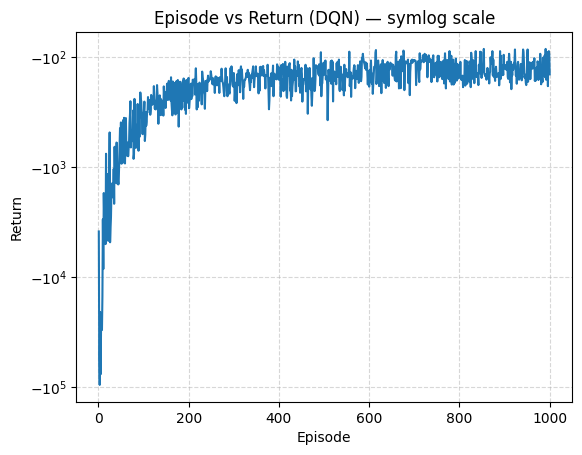

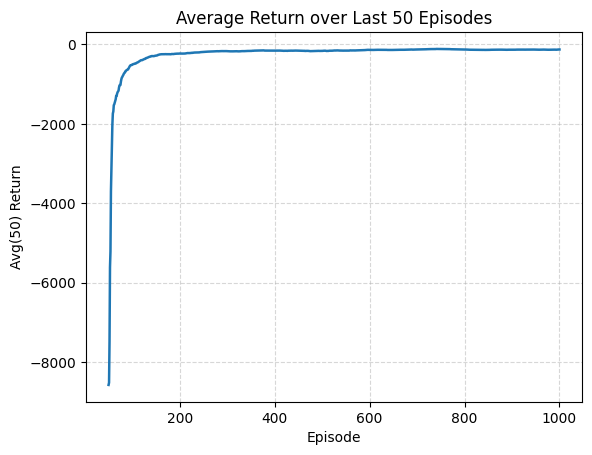

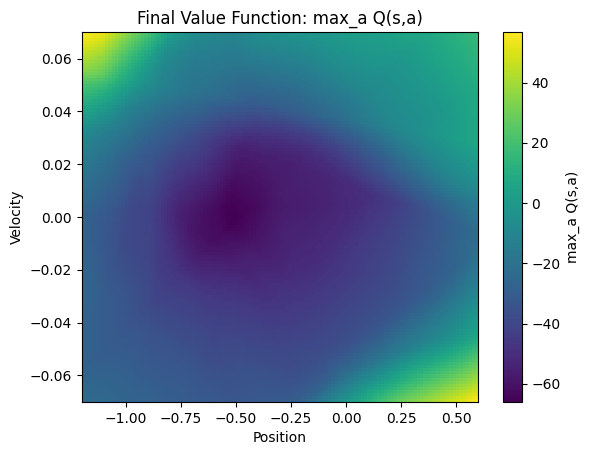

In [ ]:
## MAIN Loop ###
rewards_dqn = []

for episode in range(num_episodes):
  state = env.reset()[0]
  total_reward = 0
  done = False

  while not done:
    action = epsilon_greedy(state, epsilon)
    next_state, reward, done, _, _ = env.step(action)

    replay_buffer.append((state, action, reward, next_state, float(done)))


    train_dqn()


    state = next_state
    total_reward += reward

    if done:
        break

    # Epsilon decay per episode
  epsilon = max(epsilon_min, epsilon * epsilon_decay)

  rewards_dqn.append(total_reward)

    # (Optional) lightweight logging
  if (episode + 1) % 50 == 0:
      avg50 = np.mean(rewards_dqn[-50:]) if len(rewards_dqn) >= 50 else np.mean(rewards_dqn)
      print(f"[Ep {episode+1:4d}] Return={total_reward:7.2f}  Avg(50)={avg50:7.2f}  ε={epsilon:5.3f}  Buffer={len(replay_buffer)}")



# =========================
# POST-TRAINING PLOTS
# =========================
import matplotlib.pyplot as plt
import numpy as np

episodes_axis = np.arange(1, len(rewards_dqn) + 1)

# ---- (1) Episode vs Return (log scale) ----
plt.figure()
plt.plot(episodes_axis, rewards_dqn, linewidth=1.5)
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("Episode vs Return (DQN) — symlog scale")
plt.grid(True, which="both", linestyle="--", alpha=0.5)
# Use symmetric log so negative rewards are supported (MountainCar returns are often negative)
plt.yscale("symlog", linthresh=1.0)

# ---- (2) Avg(50) Reward ----
window = 50
if len(rewards_dqn) >= window:
    # moving average (valid part only)
    kernel = np.ones(window, dtype=float) / window
    avg50 = np.convolve(rewards_dqn, kernel, mode="valid")
    episodes_avg = np.arange(window, len(rewards_dqn) + 1)
else:
    # not enough points yet; show a simple running mean
    avg50 = np.array([np.mean(rewards_dqn[:i]) for i in range(1, len(rewards_dqn) + 1)])
    episodes_avg = episodes_axis

plt.figure()
plt.plot(episodes_avg, avg50, linewidth=1.8)
plt.xlabel("Episode")
plt.ylabel("Avg(50) Return")
plt.title("Average Return over Last 50 Episodes")
plt.grid(True, linestyle="--", alpha=0.5)

# ---- (3) Final Value Function: max_a Q(s,a) over state grid ----
# MountainCar state bounds
pos_low, vel_low = env.observation_space.low
pos_high, vel_high = env.observation_space.high

# Build a grid over (position, velocity)
N_pos, N_vel = 121, 121   # resolution (adjust if you want finer/coarser)
pos_grid = np.linspace(pos_low, pos_high, N_pos)
vel_grid = np.linspace(vel_low, vel_high, N_vel)
P, V = np.meshgrid(pos_grid, vel_grid)  # shapes [N_vel, N_pos]

grid_states = np.stack([P.ravel(), V.ravel()], axis=1)  # [N_pos*N_vel, 2]

# Evaluate max Q on the grid
q_net.eval()
with torch.no_grad():
    s = torch.tensor(grid_states, dtype=torch.float32, device=device)
    q = q_net(s)                                # [N_pos*N_vel, n_actions]
    max_q = q.max(dim=1).values.detach().cpu().numpy()  # [N_pos*N_vel]

Z = max_q.reshape(N_vel, N_pos)  # reshape to match meshgrid (rows=vel, cols=pos)

plt.figure()
im = plt.imshow(
    Z,
    origin="lower",
    extent=[pos_low, pos_high, vel_low, vel_high],
    aspect="auto"
)
plt.colorbar(im, label="max_a Q(s,a)")
plt.xlabel("Position")
plt.ylabel("Velocity")
plt.title("Final Value Function: max_a Q(s,a)")

plt.show()


# Exercise 2: Deep Q-Learning (DQN) on LunarLander-v2

## Problem Description
In this exercise, you will implement **Deep Q-Learning (DQN)** to solve the classic control problem **LunarLander-v2** in Gym.

### The Task
The agent controls a lander that starts at the top of the screen and must safely land on the landing pad between two flags.

- **State space**: Continuous vector of 8 variables, including:
  - Position (x, y)
  - Velocity (x_dot, y_dot)
  - Angle and angular velocity
  - Left/right leg contact indicators
- **Action space**: Discrete, 4 actions
  - 0: do nothing
  - 1: fire left orientation engine
  - 2: fire main engine
  - 3: fire right orientation engine
- **Rewards**:
  - +100 to +140 for successful landing
  - -100 for crashing
  - Small negative reward for firing engines (fuel cost)
  - Episode ends when lander crashes or comes to rest

The goal is to train an agent that lands successfully **most of the time**.

---

## Algorithm: Deep Q-Learning
You will implement a **DQN agent** with the following components:

1. **Q-Network**
   - Neural network that approximates Q(s, a).
   - Input: state vector (8 floats).
   - Output: Q-values for 4 actions.
   - Suggested architecture: 2 hidden layers with 128 neurons each, ReLU activation.

2. **Target Network**
   - A copy of the Q-network that is updated less frequently (e.g., every 1000 steps).
   - Used for stable target computation.

3. **Replay Buffer**
   - Stores transitions `(s, a, r, s_next, done)`.
   - Sample random mini-batches to break correlation between consecutive samples.

4. **ε-Greedy Policy**
   - With probability ε, take a random action.
   - Otherwise, take `argmax_a Q(s, a)`.
   - Decay ε over time (e.g., from 1.0 → 0.05).

5. **Q-Learning Method**
   


**Final note:**
   No code base is necessary. At this point, you must know how to implement evertything.
   For reference, but not recommended ([Here](https://colab.research.google.com/drive/1Gl0kuln79A__hgf2a-_-mwoGISXQDK_X?authuser=1#scrollTo=8Sd0q9DG8Rt8&line=56&uniqifier=1) is a solution)

---
## Deliverables
1. **Code**:
- Q-network (PyTorch).
- Training loop with ε-greedy policy, target network, and Adam optimizer.

2. **Plots**:
- Episode returns vs training episodes.
- Evaluation performance with a greedy policy (ε = 0).

3. **Short Write-up (≤1 page)**:
- Did your agent learn to land consistently?  
- How many episodes did it take before you saw improvement?  
- What effect did replay buffer size, target update frequency, and learning rate have on stability?  
- Compare results across different runs (does it sometimes fail to converge?).

Compare this task with the **MountainCar-v0** problem you solved earlier:
- What is **extra** or more challenging in LunarLander?  
- Consider state dimensionality, number of actions, reward shaping, and the difficulty of exploration.  
- Why might DQN be necessary here, whereas simpler methods (like tile coding) could work for MountainCar?


Yes


From the change of MA, there is a clear improvement after 900 episodes.


If the replay buffer is too small, the agent becomes unstable and may even fail to converge. I tested buffer sizes of 150,000, 100,000, and 50,000; the agent successfully learned to land with 150,000 and 100,000, but failed to converge with 50,000.


A higher target update frequency can improve training stability, but if it is set too high — for example, updating every 250 episodes — the agent fails to converge.


An excessively large learning rate leads to unstable training, while a very small learning rate results in slow learning. Learning rates in the range of 1e-3 to 1e-4 produce good performance.


Most runs converged to average rewards between 200–300 (all successful landing).


The LunarLander has a higher-dimensional state space and a larger action space, making it harder to discretize and explore. Moreover, the underlying physical dynamics of controlling the lander are more complex.


The reward in LunarLander is dense, but I believe this actually makes learning easier. Dense rewards provide feedback at almost every timestep, allowing the agent to improve its gradient more quickly.


The environment is high-dimensional and continuous; discretization would require millions of tiles.The reward is dense, making neural function approximation effective.The policy requires complex coordination (switching between different strategies within a short time), which is impossible for discretized tiles, since each tile applies the same policy within its range.

In [1]:
!pip install swig
!pip install "gymnasium[box2d]"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 12.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp312-cp312-linux_x86_64.whl size=2409541 sha256=9ef256e91b0456437615938c16a44a80b2d1e3b485595f55ce441c7d951f2153
  Stored in directory: /root/.cache/pip/wheels/2a/e9/60/774da0bcd07f7dc7761a8590fa2d065e4069568e78dcdc3318
Successfully built box2d-py


Device: cuda
[Ep   10] Return=-108.14  MA(50)=-149.19  ε=0.994  Steps=932  Buffer=932
[Ep   20] Return= -76.37  MA(50)=-163.53  ε=0.989  Steps=1814  Buffer=1814
[Ep   30] Return= -85.02  MA(50)=-177.92  ε=0.983  Steps=2769  Buffer=2769
[Ep   40] Return=-164.15  MA(50)=-181.08  ε=0.978  Steps=3677  Buffer=3677
[Ep   50] Return=-103.57  MA(50)=-172.23  ε=0.973  Steps=4503  Buffer=4503
[Ep   60] Return=-238.82  MA(50)=-181.55  ε=0.967  Steps=5433  Buffer=5433
[Ep   70] Return=-353.52  MA(50)=-178.00  ε=0.962  Steps=6307  Buffer=6307
[Ep   80] Return= -68.28  MA(50)=-163.00  ε=0.957  Steps=7153  Buffer=7153
[Ep   90] Return=-142.88  MA(50)=-165.62  ε=0.952  Steps=8028  Buffer=8028
[Ep  100] Return= -95.85  MA(50)=-177.73  ε=0.946  Steps=9003  Buffer=9003
[Ep  110] Return=-303.64  MA(50)=-185.49  ε=0.940  Steps=9940  Buffer=9940
[Ep  120] Return=-138.79  MA(50)=-189.23  ε=0.935  Steps=10910  Buffer=10910
[Ep  130] Return=-155.94  MA(50)=-188.37  ε=0.929  Steps=11803  Buffer=11803
[Ep  140] 

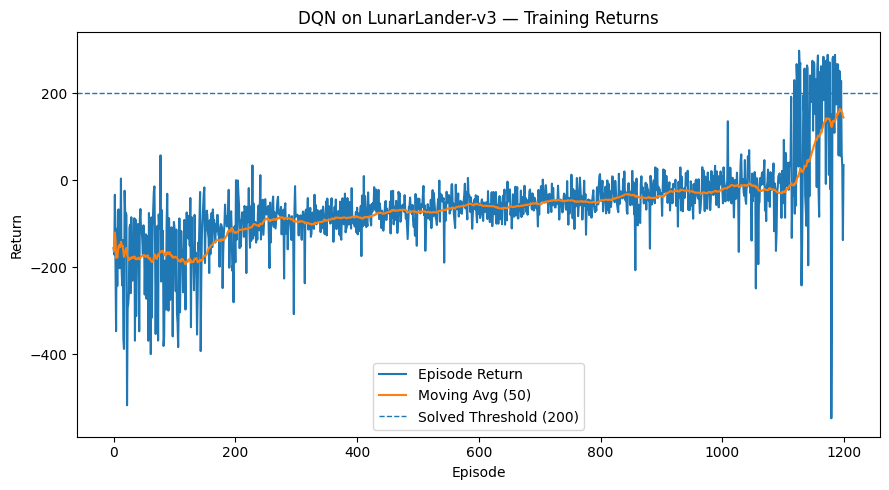

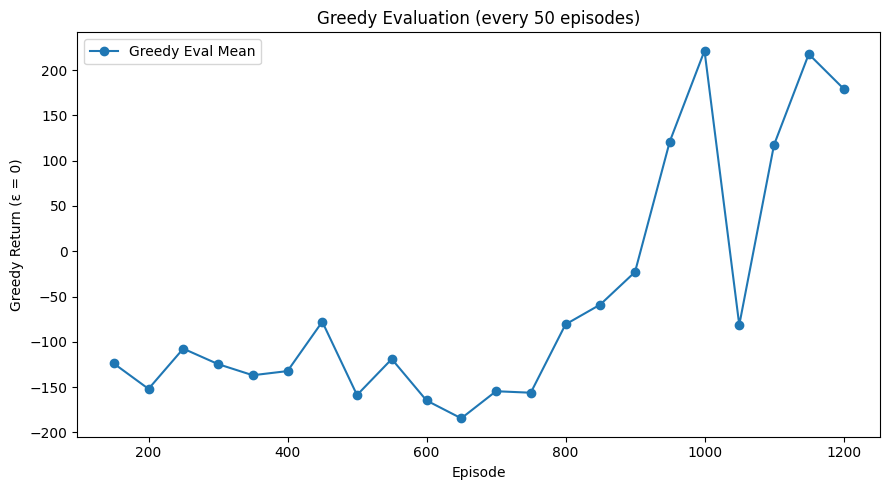

In [ ]:
# dqn_lunarlander_plot.py
import math
import random
import collections
from dataclasses import dataclass
from typing import Tuple, List

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


# ----------------------------
# Hyperparameters
# ----------------------------
ENV_ID = "LunarLander-v3"  # Gymnasium v3
SEED = 42

GAMMA = 0.99
LR = 1e-3
BATCH_SIZE = 128
REPLAY_CAPACITY = 150_000
START_LEARNING_AFTER = 10_000
TRAINING_STEPS_PER_ENV_STEP = 1
TARGET_UPDATE_FREQ = 1000

EPS_START = 1.0
EPS_END = 0.1
EPS_DECAY_STEPS = 150_000

NUM_EPISODES = 1200
MAX_STEPS_PER_EPISODE = 1000

# Evaluation config
EVAL_EPISODES = 10         # eval batch size
EVAL_INTERVAL = 50         # evaluate every N training episodes

GRAD_CLIP_NORM = 10.0


# ----------------------------
# Utilities
# ----------------------------
def set_seed(env, seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)


@dataclass
class Transition:
    s: np.ndarray
    a: int
    r: float
    s_next: np.ndarray
    done: bool


class ReplayBuffer:
    def __init__(self, capacity: int):
        self.buf = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buf)

    def push(self, *args):
        self.buf.append(Transition(*args))

    def sample(self, batch_size: int) -> Transition:
        batch = random.sample(self.buf, batch_size)
        s      = torch.tensor(np.asarray([t.s for t in batch]), dtype=torch.float32)
        a      = torch.tensor([t.a for t in batch], dtype=torch.int64).unsqueeze(-1)
        r      = torch.tensor([t.r for t in batch], dtype=torch.float32).unsqueeze(-1)
        s_next = torch.tensor(np.asarray([t.s_next for t in batch]), dtype=torch.float32)
        done   = torch.tensor([t.done for t in batch], dtype=torch.float32).unsqueeze(-1)
        return s, a, r, s_next, done


class QNetwork(nn.Module):
    def __init__(self, state_dim: int, n_actions: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions),
        )

    def forward(self, x):
        return self.net(x)


class DQNAgent:
    def __init__(self, state_dim: int, n_actions: int, device: torch.device):
        self.device = device
        self.n_actions = n_actions

        self.q = QNetwork(state_dim, n_actions).to(device)
        self.q_target = QNetwork(state_dim, n_actions).to(device)
        self.q_target.load_state_dict(self.q.state_dict())
        self.q_target.eval()

        self.optim = optim.Adam(self.q.parameters(), lr=LR)
        self.loss_fn = nn.SmoothL1Loss()
        self.replay = ReplayBuffer(REPLAY_CAPACITY)

        self.steps_done = 0

    def epsilon(self) -> float:
        f = min(1.0, self.steps_done / EPS_DECAY_STEPS)
        return EPS_START + (EPS_END - EPS_START) * f

    @torch.no_grad()
    def act(self, state: np.ndarray) -> int:
        # epsilon-greedy for training
        if random.random() < self.epsilon():
            return random.randrange(self.n_actions)
        s = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
        q_values = self.q(s)
        return int(torch.argmax(q_values, dim=1).item())

    @torch.no_grad()
    def act_greedy(self, state: np.ndarray) -> int:
        # strictly greedy: ε=0 policy
        s = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
        return int(torch.argmax(self.q(s), dim=1).item())

    def push(self, *transition):
        self.replay.push(*transition)

    def hard_update_target(self):
        self.q_target.load_state_dict(self.q.state_dict())

    def learn(self):
        if len(self.replay) < max(BATCH_SIZE, START_LEARNING_AFTER):
            return None

        s, a, r, s_next, done = self.replay.sample(BATCH_SIZE)
        s, a, r, s_next, done = s.to(self.device), a.to(self.device), r.to(self.device), s_next.to(self.device), done.to(self.device)

        # Q(s,a)
        q_pred = self.q(s).gather(1, a)

        # Target: r + gamma * (1-done) * max_a' Q_target(s', a')
        with torch.no_grad():
            q_next_max = self.q_target(s_next).max(dim=1, keepdim=True).values
            target = r + (1.0 - done) * GAMMA * q_next_max

        loss = self.loss_fn(q_pred, target)

        self.optim.zero_grad(set_to_none=True)
        loss.backward()
        nn.utils.clip_grad_norm_(self.q.parameters(), GRAD_CLIP_NORM)
        self.optim.step()

        return float(loss.item())


def evaluate(env, agent: DQNAgent, episodes=EVAL_EPISODES) -> Tuple[float, float]:
    # strictly greedy (ε = 0)
    scores: List[float] = []
    for _ in range(episodes):
        s, _ = env.reset(seed=random.randint(0, 10_000))
        done, truncated = False, False
        ep_ret = 0.0
        steps = 0
        while not (done or truncated):
            a = agent.act_greedy(s)
            s, r, done, truncated, _ = env.step(a)
            ep_ret += r
            steps += 1
            if steps > MAX_STEPS_PER_EPISODE:
                break
        scores.append(ep_ret)
    return float(np.mean(scores)), float(np.std(scores))


def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)

    env = gym.make(ENV_ID)
    set_seed(env, SEED)

    state_dim = env.observation_space.shape[0]
    n_actions = env.action_space.n
    agent = DQNAgent(state_dim, n_actions, device)

    # --- Logging ---
    returns = []           # per-episode return
    ma50 = []              # 50-episode moving average
    eval_steps = []        # episode index at which eval was done
    eval_means = []        # greedy eval mean
    eval_stds = []         # greedy eval std
    best_eval = -float("inf")

    for ep in range(1, NUM_EPISODES + 1):
        s, _ = env.reset(seed=SEED + ep)
        done, truncated = False, False
        ep_ret = 0.0

        for t in range(MAX_STEPS_PER_EPISODE):
            a = agent.act(s)
            s_next, r, done, truncated, _ = env.step(a)

            agent.push(s, a, r, s_next, done or truncated)
            s = s_next
            ep_ret += r

            # learning
            agent.steps_done += 1
            for _ in range(TRAINING_STEPS_PER_ENV_STEP):
                agent.learn()

            # target update
            if agent.steps_done % TARGET_UPDATE_FREQ == 0:
                agent.hard_update_target()

            if done or truncated:
                break

        returns.append(ep_ret)
        ma = float(np.mean(returns[-50:]))
        ma50.append(ma)

        # periodic console log
        if ep % 10 == 0:
            print(f"[Ep {ep:4d}] Return={ep_ret:7.2f}  MA(50)={ma:7.2f}  ε={agent.epsilon():.3f}  Steps={agent.steps_done}  Buffer={len(agent.replay)}")

        # periodic greedy evaluation
        if ep % EVAL_INTERVAL == 0 and len(agent.replay) > START_LEARNING_AFTER:
            eval_mean, eval_std = evaluate(env, agent, episodes=EVAL_EPISODES)
            eval_steps.append(ep)
            eval_means.append(eval_mean)
            eval_stds.append(eval_std)

            print(f"  [Eval @ Ep {ep}] Greedy mean={eval_mean:.1f} ± {eval_std:.1f}")

            if eval_mean > best_eval:
                best_eval = eval_mean
                torch.save(agent.q.state_dict(), "dqn_lunarlander_best.pt")
                print(f"  Saved best model: greedy eval {eval_mean:.1f}±{eval_std:.1f}")

    # Final greedy evaluation
    final_mean, final_std = evaluate(env, agent, episodes=max(EVAL_EPISODES, 20))
    print(f"\nFinal greedy evaluation: {final_mean:.1f} ± {final_std:.1f}")
    torch.save(agent.q.state_dict(), "dqn_lunarlander_final.pt")
    print("Saved final model to dqn_lunarlander_final.pt")

    env.close()

    # ----------------------------
    # Plots
    # ----------------------------
    # 1) Training returns per episode (+ MA(50))
    plt.figure(figsize=(9, 5))
    plt.plot(returns, label="Episode Return")
    plt.plot(ma50, label="Moving Avg (50)")
    plt.axhline(200, linestyle="--", linewidth=1, label="Solved Threshold (200)")
    plt.xlabel("Episode")
    plt.ylabel("Return")
    plt.title("DQN on LunarLander-v3 — Training Returns")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 2) Greedy evaluation curve over training
    if len(eval_steps) > 0:
        plt.figure(figsize=(9, 5))
        plt.plot(eval_steps, eval_means, marker="o", label="Greedy Eval Mean")

        plt.xlabel("Episode")
        plt.ylabel("Greedy Return (ε = 0)")
        plt.title(f"Greedy Evaluation (every {EVAL_INTERVAL} episodes)")
        plt.legend()
        plt.tight_layout()
        plt.show()


if __name__ == "__main__":
    main()


Device: cuda | Policy: softmax
[Ep   10] Return=-130.07  MA(50)=-242.68  T=0.996  Steps=832  Buffer=832
[Ep   20] Return=-125.48  MA(50)=-246.33  T=0.991  Steps=1678  Buffer=1678
[Ep   30] Return=-182.88  MA(50)=-257.93  T=0.987  Steps=2516  Buffer=2516
[Ep   40] Return=-142.84  MA(50)=-254.48  T=0.982  Steps=3313  Buffer=3313
[Ep   50] Return=-125.43  MA(50)=-243.34  T=0.978  Steps=4102  Buffer=4102
[Ep   60] Return=-306.59  MA(50)=-228.50  T=0.974  Steps=4913  Buffer=4913
[Ep   70] Return=-435.13  MA(50)=-225.93  T=0.970  Steps=5705  Buffer=5705
[Ep   80] Return= -98.43  MA(50)=-214.22  T=0.965  Steps=6475  Buffer=6475
[Ep   90] Return=-477.63  MA(50)=-215.98  T=0.961  Steps=7316  Buffer=7316
[Ep  100] Return=-178.09  MA(50)=-230.04  T=0.956  Steps=8311  Buffer=8311
[Ep  110] Return=-569.98  MA(50)=-261.87  T=0.951  Steps=9178  Buffer=9178
[Ep  120] Return=-374.17  MA(50)=-260.73  T=0.946  Steps=10083  Buffer=10083
[Ep  130] Return=  -8.26  MA(50)=-247.26  T=0.932  Steps=12692  Buffe

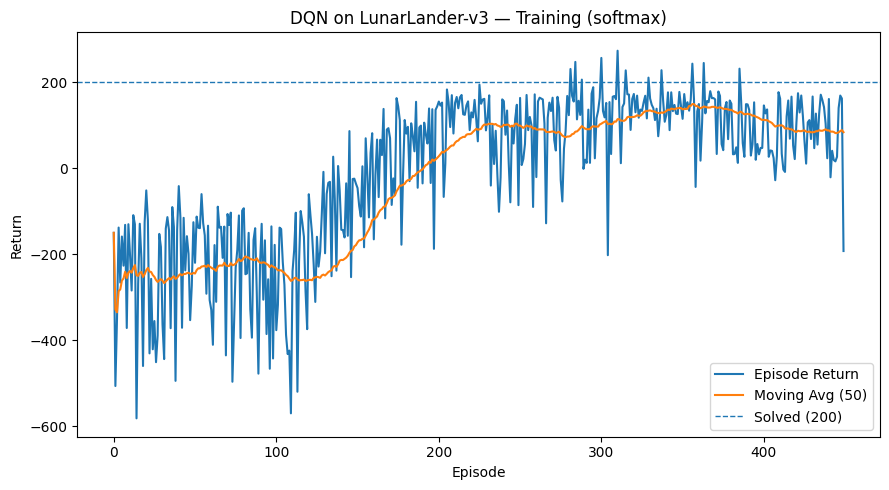

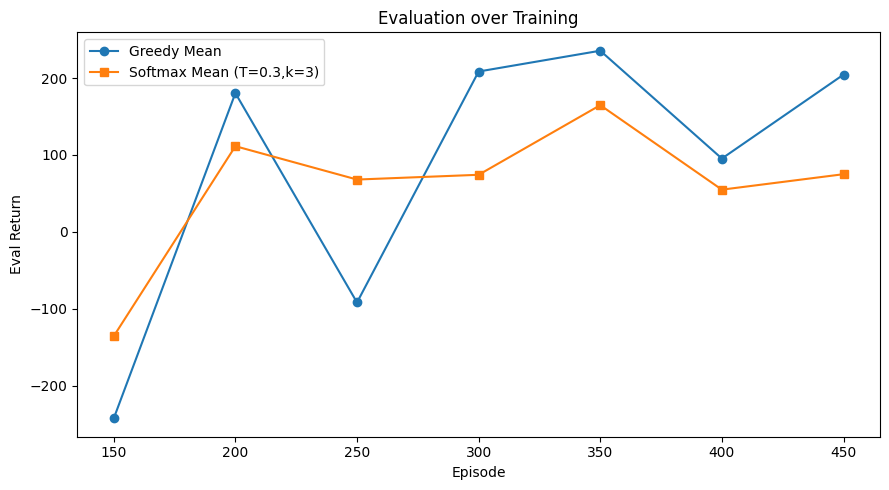

In [7]:
# tile
import random
import collections
from dataclasses import dataclass
from typing import Tuple, List, Literal, Optional

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


# =========================
# Config / Hyperparameters
# =========================
ENV_ID = "LunarLander-v3"
SEED = 42

GAMMA = 0.99
LR = 1e-3
BATCH_SIZE = 128
REPLAY_CAPACITY = 150_000
START_LEARNING_AFTER = 10_000
TRAINING_STEPS_PER_ENV_STEP = 1
TARGET_UPDATE_FREQ = 1_000          # hard update every N env steps (1000 works well)

# Exploration (ε-greedy)
EPS_START = 1.0
EPS_END = 0.05
EPS_DECAY_STEPS = 150_000

# LLM-style softmax sampling
POLICY_MODE: Literal["epsilon_greedy", "softmax"] = "softmax"
SOFTMAX_T_INIT = 1.0                 # starting temperature
SOFTMAX_T_MIN = 0.2                  # min temperature
SOFTMAX_T_DECAY_STEPS = 150_000      # linear decay steps
TOP_K: Optional[int] = 3             # sample only among top-k actions; set None to disable

NUM_EPISODES = 450
MAX_STEPS_PER_EPISODE = 1000

# Evaluation
EVAL_EPISODES = 10
EVAL_INTERVAL = 50                   # evaluate every N episodes (both greedy & softmax)

GRAD_CLIP_NORM = 10.0


# ===============
# Utilities
# ===============
def set_seed(env, seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)


@dataclass
class Transition:
    s: np.ndarray
    a: int
    r: float
    s_next: np.ndarray
    done: bool


class ReplayBuffer:
    def __init__(self, capacity: int):
        self.buf = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buf)

    def push(self, *args):
        self.buf.append(Transition(*args))

    def sample(self, batch_size: int) -> Transition:
        batch = random.sample(self.buf, batch_size)
        s      = torch.tensor(np.asarray([t.s for t in batch]), dtype=torch.float32)
        a      = torch.tensor([t.a for t in batch], dtype=torch.int64).unsqueeze(1)
        r      = torch.tensor([t.r for t in batch], dtype=torch.float32).unsqueeze(1)
        s_next = torch.tensor(np.asarray([t.s_next for t in batch]), dtype=torch.float32)
        done   = torch.tensor([t.done for t in batch], dtype=torch.float32).unsqueeze(1)
        return s, a, r, s_next, done


class QNetwork(nn.Module):
    def __init__(self, state_dim: int, n_actions: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, n_actions),
        )
    def forward(self, x):
        return self.net(x)


class DQNAgent:
    def __init__(self, state_dim: int, n_actions: int, device: torch.device):
        self.device = device
        self.n_actions = n_actions

        self.q = QNetwork(state_dim, n_actions).to(device)
        self.q_target = QNetwork(state_dim, n_actions).to(device)
        self.q_target.load_state_dict(self.q.state_dict())
        self.q_target.eval()

        self.optim = optim.Adam(self.q.parameters(), lr=LR)
        self.loss_fn = nn.SmoothL1Loss()
        self.replay = ReplayBuffer(REPLAY_CAPACITY)

        self.steps_done = 0

    # ---------- Schedules ----------
    def epsilon(self) -> float:
        f = min(1.0, self.steps_done / EPS_DECAY_STEPS)
        return EPS_START + (EPS_END - EPS_START) * f

    def temperature(self) -> float:
        f = min(1.0, self.steps_done / SOFTMAX_T_DECAY_STEPS)
        return SOFTMAX_T_INIT + (SOFTMAX_T_MIN - SOFTMAX_T_INIT) * f

    # ---------- Action selection ----------
    @torch.no_grad()
    def act(self, state: np.ndarray) -> int:
        """
        Training policy:
        - "epsilon_greedy": ε-greedy over Q
        - "softmax": Boltzmann/softmax over Q with temperature and optional top-k
        """
        if POLICY_MODE == "epsilon_greedy":
            if random.random() < self.epsilon():
                return random.randrange(self.n_actions)
            s = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
            return int(torch.argmax(self.q(s), dim=1).item())

        elif POLICY_MODE == "softmax":
            s = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
            q = self.q(s).squeeze(0).cpu().numpy()
            T = max(1e-6, self.temperature())
            logits = q / T
            # stabilize
            logits = logits - np.max(logits)
            probs = np.exp(logits)
            probs /= np.sum(probs)

            if TOP_K is not None and TOP_K < self.n_actions:
                top_idx = np.argsort(probs)[-TOP_K:]
                top_probs = probs[top_idx]
                top_probs = top_probs / top_probs.sum()
                return int(np.random.choice(top_idx, p=top_probs))
            else:
                return int(np.random.choice(np.arange(self.n_actions), p=probs))
        else:
            raise ValueError("Unknown POLICY_MODE")

    @torch.no_grad()
    def act_greedy(self, state: np.ndarray) -> int:
        s = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
        return int(torch.argmax(self.q(s), dim=1).item())

    @torch.no_grad()
    def act_softmax_eval(self, state: np.ndarray, T: float = 0.3, k: Optional[int] = 2) -> int:
        """Evaluation-time softmax sampler (e.g., small T for mild stochasticity)."""
        s = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
        q = self.q(s).squeeze(0).cpu().numpy()
        logits = q / max(1e-6, T)
        logits = logits - np.max(logits)
        probs = np.exp(logits); probs /= probs.sum()
        if k is not None and k < self.n_actions:
            top_idx = np.argsort(probs)[-k:]
            top_probs = probs[top_idx]; top_probs /= top_probs.sum()
            return int(np.random.choice(top_idx, p=top_probs))
        return int(np.random.choice(np.arange(self.n_actions), p=probs))

    # ---------- Target network ----------
    def hard_update_target(self):
        self.q_target.load_state_dict(self.q.state_dict())

    # ---------- Learning ----------
    def learn(self):
        if len(self.replay) < max(BATCH_SIZE, START_LEARNING_AFTER):
            return None

        s, a, r, s_next, done = self.replay.sample(BATCH_SIZE)
        s, a, r, s_next, done = s.to(self.device), a.to(self.device), r.to(self.device), s_next.to(self.device), done.to(self.device)

        q_pred = self.q(s).gather(1, a)

        # Standard DQN target; swap to Double DQN if you want (commented below)
        with torch.no_grad():
            q_next_max = self.q_target(s_next).max(dim=1, keepdim=True).values
            target = r + (1.0 - done) * GAMMA * q_next_max

            # --- Double DQN alternative ---
            next_actions = self.q(s_next).argmax(dim=1, keepdim=True)
            q_next_target = self.q_target(s_next).gather(1, next_actions)
            target = r + (1.0 - done) * GAMMA * q_next_target

        loss = self.loss_fn(q_pred, target)
        self.optim.zero_grad(set_to_none=True)
        loss.backward()
        nn.utils.clip_grad_norm_(self.q.parameters(), GRAD_CLIP_NORM)
        self.optim.step()

        return float(loss.item())


# ===============
# Evaluation
# ===============
def evaluate_greedy(env, agent: DQNAgent, episodes=EVAL_EPISODES) -> Tuple[float, float]:
    scores: List[float] = []
    for _ in range(episodes):
        s, _ = env.reset(seed=random.randint(0, 10_000))
        done = truncated = False
        ep_ret = 0.0
        steps = 0
        while not (done or truncated):
            a = agent.act_greedy(s)
            s, r, done, truncated, _ = env.step(a)
            ep_ret += r
            steps += 1
            if steps > MAX_STEPS_PER_EPISODE:
                break
        scores.append(ep_ret)
    return float(np.mean(scores)), float(np.std(scores))


def evaluate_softmax(env, agent: DQNAgent, episodes=EVAL_EPISODES, T=0.3, k: Optional[int] = 2) -> Tuple[float, float]:
    scores: List[float] = []
    for _ in range(episodes):
        s, _ = env.reset(seed=random.randint(0, 10_000))
        done = truncated = False
        ep_ret = 0.0
        steps = 0
        while not (done or truncated):
            a = agent.act_softmax_eval(s, T=T, k=k)
            s, r, done, truncated, _ = env.step(a)
            ep_ret += r
            steps += 1
            if steps > MAX_STEPS_PER_EPISODE:
                break
        scores.append(ep_ret)
    return float(np.mean(scores)), float(np.std(scores))


# ===============
# Training
# ===============
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device, "| Policy:", POLICY_MODE)

    env = gym.make(ENV_ID)
    set_seed(env, SEED)

    state_dim = env.observation_space.shape[0]
    n_actions = env.action_space.n
    agent = DQNAgent(state_dim, n_actions, device)

    returns = []
    ma50 = []
    eval_steps = []
    eval_greedy_means = []
    eval_greedy_stds = []
    eval_soft_means = []
    eval_soft_stds = []

    best_greedy = -float("inf")

    for ep in range(1, NUM_EPISODES + 1):
        s, _ = env.reset(seed=SEED + ep)
        done = truncated = False
        ep_ret = 0.0

        for t in range(MAX_STEPS_PER_EPISODE):
            a = agent.act(s)
            s_next, r, done, truncated, _ = env.step(a)

            agent.replay.push(s, a, r, s_next, done or truncated)
            s = s_next
            ep_ret += r

            # learning
            agent.steps_done += 1
            for _ in range(TRAINING_STEPS_PER_ENV_STEP):
                agent.learn()

            # target update
            if agent.steps_done % TARGET_UPDATE_FREQ == 0:
                agent.hard_update_target()

            if done or truncated:
                break

        returns.append(ep_ret)
        ma = float(np.mean(returns[-50:]))
        ma50.append(ma)

        if ep % 10 == 0:
            if POLICY_MODE == "softmax":
                print(f"[Ep {ep:4d}] Return={ep_ret:7.2f}  MA(50)={ma:7.2f}  T={agent.temperature():.3f}  Steps={agent.steps_done}  Buffer={len(agent.replay)}")
            else:
                print(f"[Ep {ep:4d}] Return={ep_ret:7.2f}  MA(50)={ma:7.2f}  ε={agent.epsilon():.3f}  Steps={agent.steps_done}  Buffer={len(agent.replay)}")

        # periodic evaluation: greedy + softmax (small T)
        if ep % EVAL_INTERVAL == 0 and len(agent.replay) > START_LEARNING_AFTER:
            g_mean, g_std = evaluate_greedy(env, agent, episodes=EVAL_EPISODES)
            s_mean, s_std = evaluate_softmax(env, agent, episodes=EVAL_EPISODES, T=0.3, k=TOP_K)

            eval_steps.append(ep)
            eval_greedy_means.append(g_mean)
            eval_greedy_stds.append(g_std)
            eval_soft_means.append(s_mean)
            eval_soft_stds.append(s_std)

            print(f"  [Eval @ Ep {ep}] Greedy mean={g_mean:.1f} ± {g_std:.1f} | Softmax(T=0.3,k={TOP_K}) mean={s_mean:.1f} ± {s_std:.1f}")

            if g_mean > best_greedy:
                best_greedy = g_mean
                torch.save(agent.q.state_dict(), "dqn_lunarlander_best.pt")
                print(f"  Saved best model (greedy): {g_mean:.1f}±{g_std:.1f}")

    # Final evals
    g_mean, g_std = evaluate_greedy(env, agent, episodes=max(EVAL_EPISODES, 20))
    s_mean, s_std = evaluate_softmax(env, agent, episodes=max(EVAL_EPISODES, 20), T=0.3, k=TOP_K)
    print(f"\nFinal Greedy: {g_mean:.1f} ± {g_std:.1f}")
    print(f"Final Softmax(T=0.3,k={TOP_K}): {s_mean:.1f} ± {s_std:.1f}")

    torch.save(agent.q.state_dict(), "dqn_lunarlander_final.pt")
    print("Saved final model to dqn_lunarlander_final.pt")

    env.close()

    # ==========
    # Plots
    # ==========
    plt.figure(figsize=(9, 5))
    plt.plot(returns, label="Episode Return")
    plt.plot(ma50, label="Moving Avg (50)")
    plt.axhline(200, linestyle="--", linewidth=1, label="Solved (200)")
    plt.xlabel("Episode"); plt.ylabel("Return")
    plt.title(f"DQN on LunarLander-v3 — Training ({POLICY_MODE})")
    plt.legend(); plt.tight_layout(); plt.show()

    if len(eval_steps) > 0:
        plt.figure(figsize=(9, 5))
        plt.plot(eval_steps, eval_greedy_means, marker="o", label="Greedy Mean")
        plt.plot(eval_steps, eval_soft_means, marker="s", label=f"Softmax Mean (T=0.3,k={TOP_K})")
        plt.xlabel("Episode"); plt.ylabel("Eval Return")
        plt.title("Evaluation over Training")
        plt.legend(); plt.tight_layout(); plt.show()


if __name__ == "__main__":
    main()
